# Geomatrical shape classification
In this notebook, we learn how to create full deep learning project in PyTorch, in which a network is trained to classify geometrical shapes in images.

In [2]:
# importing the necessary packages/libraries
import numpy as np
import random

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as torch_transforms

import cv2
from matplotlib import pyplot as plt

# Dataset 

The first step is to get the data ready.

## dataset-utility functions.
First we create all the ulitiy functions to generate a set of images

In [4]:
def create_random_background(img_size, p=0.5):
    """This functions creates a background image."""
    # if the random value larger than 0.5, the background will be random noise, otherwise, random uniform
    if np.random.rand() > p:
        return np.random.randint(0, 256, (img_size, img_size, 3), dtype='uint8')
    else:
        return np.zeros((img_size, img_size, 3), dtype='uint8') + np.random.randint(0, 256, dtype='uint8')

def create_random_shape(img, filled):
    """This functions generates geometrical shapes on top of a background image."""
    # choosing a colour for the shape, there is a slim chance of being identical to the background,
    # we can consider this the noise in our dataset!
    colour = [random.randint(0, 255) for _ in range(3)]
    thickness = np.random.randint(2, 7)
    point1 = np.random.randint(img.shape[0] // 4, 3 * (img.shape[0] // 4), 2)
    
    # drawing a random geomterical shape
    shape_ind = np.random.randint(0, 3)
    # when the tickness is negative, the shape is drawn filled
    thickness *= -1 if filled else np.random.choice([-1, 1])
    
    if shape_ind == 0: # circle
        radius = np.random.randint(10, img.shape[0] // 4)
        img = cv2.circle(img, point1, radius, color=colour, thickness=thickness)
    elif shape_ind == 1: # ellipse
        axes = [
            np.random.randint(10, 20),
            np.random.randint(30, img.shape[0] // 4)
        ]
        angle = np.random.randint(0, 360)
        img = cv2.ellipse(img, point1, axes, angle, 0, 360, color=colour, thickness=thickness)
    else: # rectangle
        point2 = np.random.randint(0, img.shape[0], 2)
        img = cv2.rectangle(img, point1, point2, color=colour, thickness=thickness)
    
    # shape_ind=0 circle
    # shape_ind=1 ellipse
    # shape_ind=2 rectangle
    return img, shape_ind

def make_image_set(num_imgs, img_size, bg_p, filled):
    """Creating the set of images."""
    imgs = []
    gts = []
    for i in range(num_imgs):
        # creating the background, either a random uniform colour, or random noise
        img = create_random_background(img_size, bg_p)
        # drawing a random shape
        img, gt = create_random_shape(img, filled)
        imgs.append(img)
        gts.append(gt)
    return imgs, gts

## train/test sets

Usually, a dataset contains three sets:

*   **Training**: the set in which the knowledge of a network is learnt from.
*   **Validation**: this set is usually used for hyper parameter tunning.
*   **Testing**: evaluating the model based on various metrics.

A rule of thumb to split your data: 70% training, 15% validation, 15% testing.

![train/validation/test](https://blog.kakaocdn.net/dn/UenrJ/btrk6fXBfbJ/4iGSlrWj4mVJxzmup2KVr1/img.png)

In our example, we create two sets of images. One for training another for testing. We skipped the validation, because we're not doing any hyper parameter tunning.

In [5]:
# definying the parametrs of the dataset
img_size = 128

number_trains = 1000
number_test = number_trains // 10

train_imgs, train_gts = make_image_set(number_trains, img_size, bg_p=1, filled=True)
test_imgs, test_gts = make_image_set(number_test, img_size, bg_p=1, filled=True)

## dataset visualisation

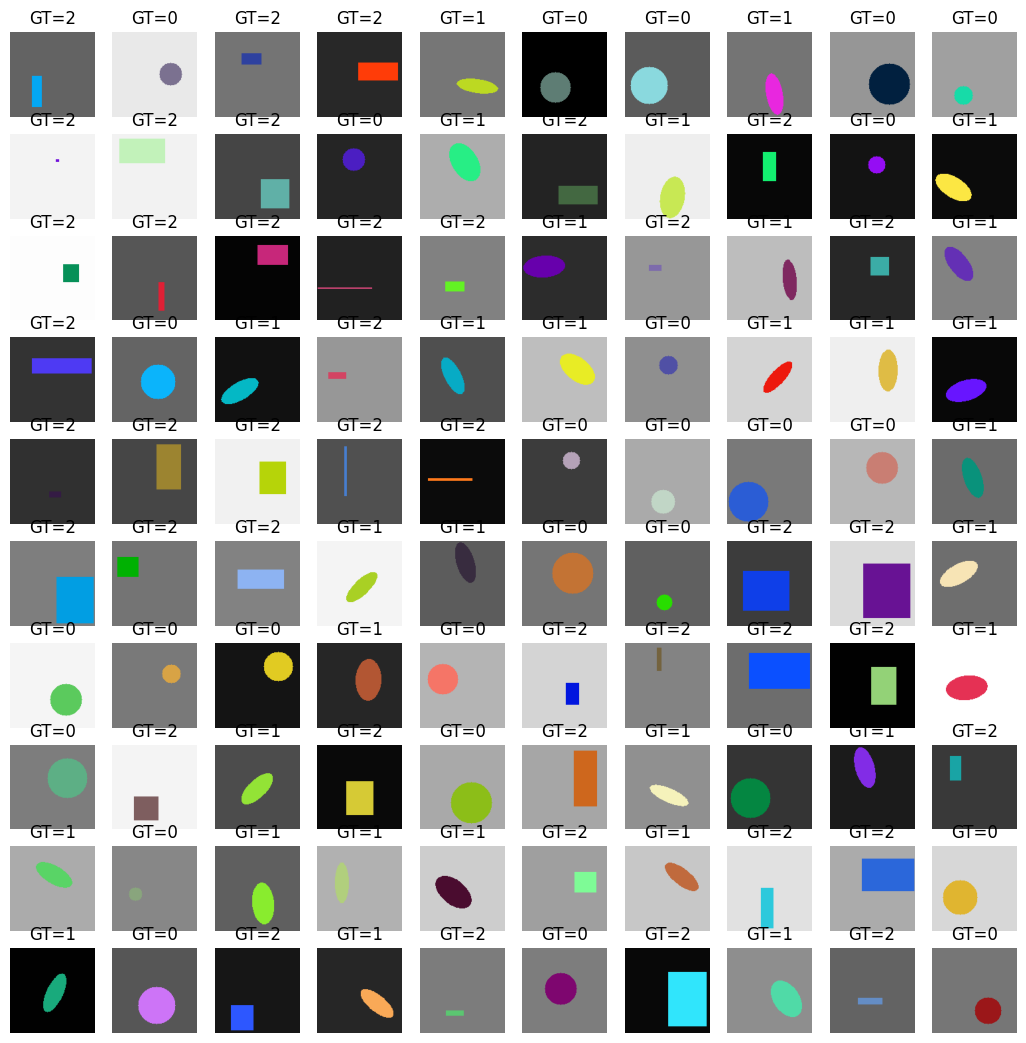

In [6]:
# plot 100 of the images
fig = plt.figure(figsize=(13, 13))
for i in range(100):
    ax = fig.add_subplot(10, 10, i+1)
    ax.imshow(train_imgs[i])
    ax.axis('off')
    ax.set_title('GT=%d' % train_gts[i])

## PyTorch Data Pipeline

Now, that we have created our dataset, we have to create PyTorch dataloaders.

In this example, we're creating a simple dataloader class ```ShapeDataset``` that inherits the ```torch.utils.data.Dataset``` class. It has to implement two functioons: ```__len__``` (return the number of samples in the dataset) and ```__getitem__``` that yield the approperiate data. 

Usually, the datasets used in deep-learning projects are huge (e.g., ImageNet contains 1.5 million images). Therefore, we cannot load all images in the memory and we read each image dynamically in the ```__getitem__``` function. 


In [7]:
# PyTorch dataset
class ShapeDataset(torch.utils.data.Dataset):

    def __init__(self, imgs, gts, transform=None):
        self.imgs = imgs
        self.gts = gts
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        # idx is the sample number
        img = self.imgs[idx]
        gt = self.gts[idx] # the ground-truth for the image, i.e. shape-ID

        if self.transform:
            img = self.transform(img)

        return img, gt

### transform functions

Deep networks are trained betetr and faster when the data is centered at 0. For this reason, we apply the ```Normalize```functions with specific ```mean``` and ```std```. Furthermore, the data must be converted to torch tensors by calling ```ToTensor``` function.

In [8]:
# make the pytorch datasets
mean = 0.5
std = 0.25
transform = torch_transforms.Compose([
    torch_transforms.ToTensor(),
    torch_transforms.Normalize(mean, std),
])

## Dataloaders

The dataloaders allow us to handle large datasets in several batches. The ```DataLoader``` class receives a numebr of parameters, such as the ```batch_size``` and ```num_workers```, etc.
**Note**: these parameters don't have to be identical in train/test scenarios. For example, we often can afford larger ```batch_size``` in test time because gradients don't need to be computed. We also don't want to ```shuffle``` the data at test time, contraray to this, we often want to ```shuffle``` the training samples.

In [9]:
train_dataset = ShapeDataset(train_imgs, train_gts, transform)

batch_size = 8
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=2, pin_memory=True, sampler=None
)

val_dataset = ShapeDataset(test_imgs, test_gts, transform)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=2, pin_memory=True, sampler=None
)

# Model

Now that we have sucessfully generated our images and created approperiate PyTorch dataloaders, we can define our network.

## architecture

The task we're modelling is relativeley simple and we don't need a complex network. Our model inherits the ```torch.nn.Module``` class and has to at least implement one function ```forward```.

In the ```__init__``` function, we define the architecure. In this case, the feature processing part consists of three convolutional blocks followed by batch normalisation, ReLU rectification and max pooling. The classifier is a linear function.

In [10]:
## creating model
class SimpleNet(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), # in=3, out=16
            nn.BatchNorm2d(16), # it must be the same as out of prvious layer
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # in=16 (it must be the same as out of previous layer)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # global average across the entire spatial resolution
        self.classifier = nn.Linear(1*1*64, num_classes) # input=64 (must be the same size as out of previous layer after vectorisation)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # the input x is processed with the network
        x = self.features(x)
        x = self.avgpool(x)
        # we vectorise the x, classifier expect a 1D array.
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## network

Next we make an instance of our previously defined architecture.
We move the model to GPU and print the model.

In [11]:
## makign the model
model = SimpleNet(num_classes=4)
model = model.cuda()
model

SimpleNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (classifier): Linear(in_features=64, out_features=4, bias=True)
)

# Training

We have our dataset and model ready. It's time to start the training.

## optimizer

First, we define what parameters we want to optimise.
**Note**: we neither have to optimise all the parameters, nor optimise all with the same ```learning_rate```.

For our purpose, the most important parameter is the ```learning_rate```.
![learning-rate](https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png)

In [12]:
# optimizer and criterion
params_to_optimize = [{'params': [p for p in model.parameters()]}]
momentum = 0.9
learning_rate = 0.01
weight_decay = 1e-4
optimizer = torch.optim.SGD(
    params_to_optimize, lr=learning_rate,
    momentum=momentum, weight_decay=weight_decay
)

## loss-functoin

In this case, we define our loss function as the categorical cross entropy

In [13]:
criterion = nn.CrossEntropyLoss().cuda()

## training utility functions

**Important**: when evaluating a model ```eval()``` function must be called, otherwise the parameters of the model will be updated!

**Important**: ```torch.set_grad_enabled``` must be set to ```True``` during training and ```False``` during testing.

In [14]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def epoch_loop(model, db_loader, criterion, optimiser):
    # usually the code for train/test has a large overlap.
    is_train = False if optimiser is None else True

    # model should be in train/eval model accordingly
    model.train() if is_train else model.eval()
    
    accuracies = []
    losses = []
    with torch.set_grad_enabled(is_train):
        for batch_ind, (img, target) in enumerate(db_loader):
            # moving the image and GT to CUDA
            img = img.cuda()
            target = target.cuda()
            output = model(img)
            
            # computing the loss function
            loss = criterion(output, target)
            losses.extend([loss.item() for i in range(img.size(0))])
            # computing the accuracy
            acc = accuracy(output, target)[0].cpu().numpy()
            accuracies.extend([acc[0] for i in range(img.size(0))])
            
            if is_train:
                # compute gradient and do SGD step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    return accuracies, losses

## epoch

We have everything (dataset, model, loss/optimiser), so we can start the training loop.

In [15]:
# doing epoch
epochs = 10
initial_epoch = 0
train_logs = {'acc': [], 'loss': []}
val_logs = {'acc': [], 'loss': []}
for epoch in range(initial_epoch, epochs):
    train_log = epoch_loop(model, train_loader, criterion, optimizer)
    
    val_log = epoch_loop(model, val_loader, criterion, None)
    
    print('[%.2d] Train     loss=%.4f     acc=%0.2f    [%.2d] Test     loss=%.4f     acc=%0.2f' % 
          (
              epoch, np.mean(train_log[1]), np.mean(train_log[0]),
              epoch, np.mean(val_log[1]), np.mean(val_log[0])
          ))
    train_logs['acc'].append(np.mean(train_log[0]))
    train_logs['loss'].append(np.mean(train_log[1]))
    val_logs['acc'].append(np.mean(val_log[0]))
    val_logs['loss'].append(np.mean(val_log[1]))

[00] Train     loss=1.1644     acc=37.10    [00] Test     loss=1.2447     acc=37.00
[01] Train     loss=1.1148     acc=40.30    [01] Test     loss=1.2138     acc=34.00
[02] Train     loss=1.0882     acc=42.00    [02] Test     loss=1.0808     acc=45.00
[03] Train     loss=0.9817     acc=51.30    [03] Test     loss=1.0930     acc=43.00
[04] Train     loss=0.9196     acc=53.40    [04] Test     loss=1.0878     acc=45.00
[05] Train     loss=0.7879     acc=58.60    [05] Test     loss=1.0713     acc=48.00
[06] Train     loss=0.6900     acc=64.70    [06] Test     loss=0.8192     acc=55.00
[07] Train     loss=0.7095     acc=64.60    [07] Test     loss=1.0312     acc=50.00
[08] Train     loss=0.6509     acc=64.70    [08] Test     loss=0.7786     acc=57.00
[09] Train     loss=0.6617     acc=62.10    [09] Test     loss=0.8083     acc=56.00


## plotting

Let's look at the accuracies and losses.
These figures can help us to evaluate whether the hyper parameters are good.

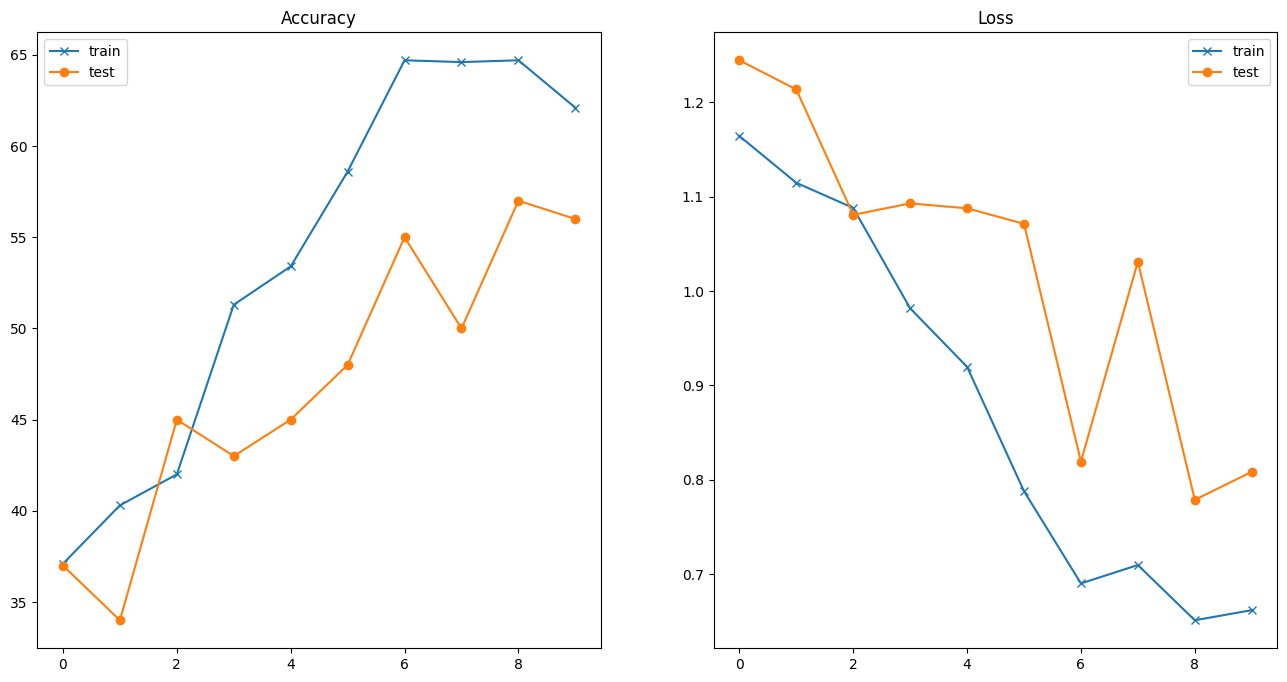

In [16]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_logs['acc'], '-x', label='train')
ax.plot(val_logs['acc'], '-o', label='test')
ax.set_title('Accuracy')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(train_logs['loss'], '-x', label='train')
ax.plot(val_logs['loss'], '-o', label='test')
ax.set_title('Loss')
ax.legend()